In [1]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

pd.set_option("display.max_rows", None)

In [2]:
users_re = re.compile(r'u(\d+)')
duration_re  = re.compile(r'd(\d+)')

In [3]:
def parse_name(path):
    name = os.path.splitext(os.path.basename(path))[0]
    users = 0
    duration = 0
    endpoint = ''
    
    for part in name.split('-'):
        match = users_re.match(part)
        if match:
            users = int(match.group(1))
            continue

        match = duration_re.match(part)
        if match:
            duration = int(match.group(1))
            continue

        if part in ['verif', 'prov']:
            endpoint = part
    
    return (users, duration, endpoint)

In [4]:
def read_request_stats(path):
    df = pd.read_csv(path)
    amend_df_from_filename(df, path)

    
    def __collapse_sessions(x):
        if x.startswith('/challenge-response'):
            parts = x.split('/')
            if len(parts[-1].split('-')) == 5: # last path segment has four '-', and so is assumed to be a UUID
                return '/'.join(parts[:-1] + ['SESSION_ID'])
        return x
    
    df['path'] = df['path'].apply(__collapse_sessions)
    
    return df

In [5]:
def amend_df_from_filename(df, path):
    users, duration, endpoint = parse_name(path)

    df['users'] = users
    df['duration'] = duration
    df['endpoint'] = endpoint
    df['file'] = os.path.basename(path)
    

In [6]:
def read_errors(path):
    df = pd.read_csv(path, names=['file', 'errors'])
    meta = df.file.apply(parse_name).apply(pd.Series).rename({0: "users", 1: "duration", 2: "endpoint"}, axis=1)
    return pd.concat([df, meta], axis=1)


In [7]:
def read_result_set(path):
    data_frames = [] 
    errors_frame = None
    
    for filepath in glob(os.path.join(path, '*.csv')):
        if os.path.basename(filepath) == 'errors.csv':
            errors_frame = read_errors(filepath)
        else:
            data_frames.append(read_request_stats(filepath))
        
    return pd.concat(data_frames, axis=0), errors_frame

In [8]:
def round_upto(val, step):
    n = int(val // step)  + 1 
    if n > 1:
        return n * step
    else:
        return val

In [15]:
axis_step = 5

def plot_req_stats(df, path, method, endpoint):
    req = df[(df['path'] == path) & (df['method'] == method)].groupby('users')['time']
    yerr = req.sem()*1.96
    ax = req.mean().plot(color='#1f77b4', yerr=yerr, style='.-')
    ax.grid()

    ax.set_ylabel("request time (ms)", color='#1f77b4')

    ax2 = ax.twinx()
    if errs is not None:
        req_errs = errs[errs['endpoint'] ==  endpoint][['users', 'errors']].set_index('users')
        req_errs.plot(color='#ff7f0e', style='.-', ax=ax2)
        ax2.legend().set_visible(False)
        ax2.set_ylabel("number of errors", color='#ff7f0e')
    
        ylim = round_upto(max((req.mean() + yerr).max(), req_errs.max().max()), axis_step)
    else:
        ylim = round_upto(req.mean().max(), axis_step)
    
    ax.set_ylim(0, ylim)
    ax2.set_ylim(0, ylim)

    fig = ax.get_figure()
    fig.suptitle(f"{method} {path}")
    
    return fig

In [10]:
config = 'adrenaline-plug-mem'
path = f'raw/{config}-set2'

df, errs = read_result_set(path)

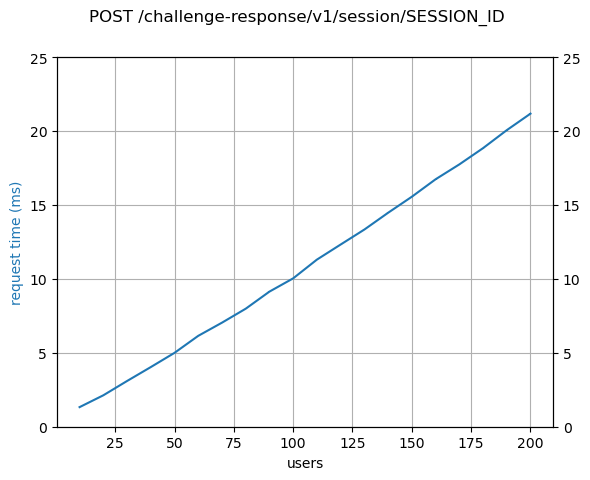

In [11]:
fig = plot_req_stats(df, '/challenge-response/v1/session/SESSION_ID', 'POST', 'verif')

fig.savefig(f'figs/verif-stats-{config}.png', transparent=True)

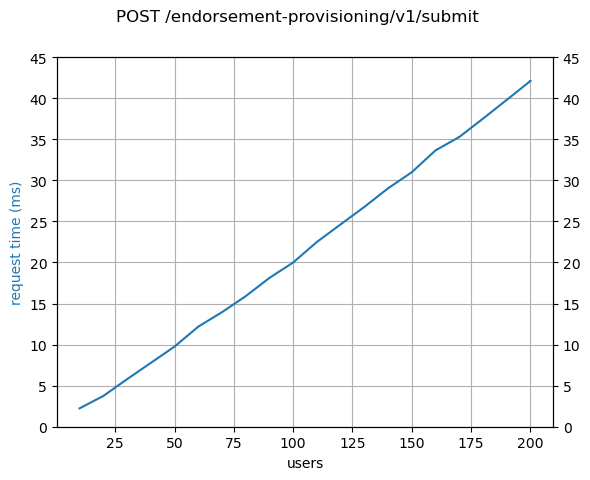

In [12]:
fig = plot_req_stats(df, '/endorsement-provisioning/v1/submit', 'POST', 'prov')

fig.savefig(f'figs/prov-stats-{config}.png', transparent=True)

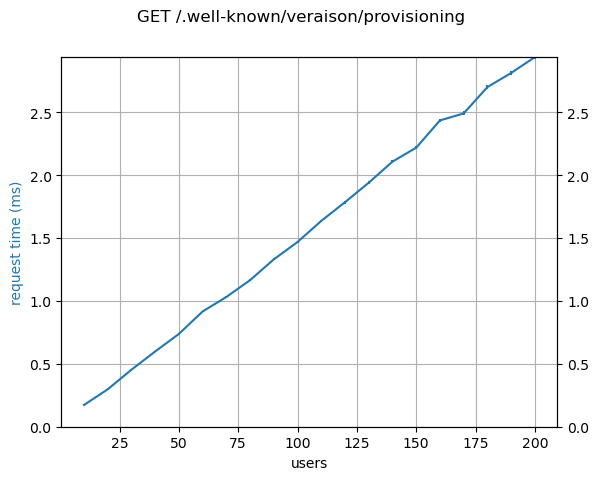

In [13]:
fig = plot_req_stats(df, '/.well-known/veraison/provisioning', 'GET', 'prov')

fig.savefig(f'figs/wellknown-stats-{config}.png', transparent=True)

In [14]:
df.groupby('path')['file'].count()

path
/.well-known/veraison/provisioning                                                      1073131
/challenge-response/v1/newSession?nonce=QUp8F0FBs9DpodKK8xUg8NQimf6sQAfe2J1ormzZLxk=    1409272
/challenge-response/v1/session/SESSION_ID                                               2817436
/endorsement-provisioning/v1/submit                                                     1075597
Name: file, dtype: int64